In [3]:
!pip install deepchem rdkit torch-geometric

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import deepchem as dc
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import NNConv, GATConv, EdgeConv, global_mean_pool, SAGPooling, GraphNorm
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import time

In [6]:
data = pd.read_csv('/kaggle/input/smiles-props/qm9_smiles_prop.csv') 
smiles_list = data['SMILES']
properties = data['G']

In [7]:
def smiles_to_graph(smiles, property_value):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
    features = featurizer.featurize([smiles])
    if not features:
        return None

    atom_features = features[0].node_features
    edge_index = torch.tensor(features[0].edge_index, dtype=torch.long)
    edge_features = features[0].edge_features

    x = torch.tensor(atom_features, dtype=torch.float)
    y = torch.tensor([property_value], dtype=torch.float)
    edge_attr = torch.tensor(edge_features, dtype=torch.float)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

data_list = [smiles_to_graph(smiles, prop) for smiles, prop in zip(smiles_list, properties)]
data_list = [d for d in data_list if d is not None]  

<ipython-input-7-431ab471bb50>:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not features:


In [8]:
class GNN(torch.nn.Module):
    def __init__(self, node_feat_dim, edge_feat_dim, hidden_dims=[128, 64], 
                 aggr='mean', attn_heads=4, use_attention=True, mlp_layers=[64, 128, 64, 1]):
        """
        Parameters:
        - node_feat_dim: int, Number of node features.
        - edge_feat_dim: int, Number of edge features.
        - hidden_dims: list, Hidden dimensions for each NNConv layer.
        - aggr: str, Aggregation type ('mean', 'sum', 'max').
        - attn_heads: int, Number of attention heads for GAT.
        - use_attention: bool, Whether to apply attention at the end of each layer.
        - mlp_layers: list, Fully connected MLP layers after pooling.
        """
        super(GNN, self).__init__()
        self.num_layers = len(hidden_dims)
        self.convs = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()
        self.edge_nns = torch.nn.ModuleList()
        self.attn_layers = torch.nn.ModuleList()
        
        prev_dim = node_feat_dim
        for i, h_dim in enumerate(hidden_dims):
            # Define the edge network to transform edge features
            edge_nn = Sequential(
                Linear(edge_feat_dim, h_dim),
                ReLU(),
                Linear(h_dim, prev_dim * h_dim)  # output dimensionality will be prev_dim * h_dim
            )
            self.edge_nns.append(edge_nn)
            
            # Define the NNConv layer, passing the edge_nn as the transformation function
            edge_conv = NNConv(in_channels=prev_dim, out_channels=h_dim, 
                               nn=edge_nn, aggr=aggr)
            self.convs.append(edge_conv)
            
            # GraphNorm for normalizing the node features
            self.norms.append(GraphNorm(h_dim))
            
            # Add attention layers if required
            if use_attention:
                self.attn_layers.append(GATConv(h_dim, h_dim // attn_heads, heads=attn_heads, concat=True))
          
            prev_dim = h_dim
        
        # Define the MLP layers after pooling
        mlp_layers_seq = []
        for i in range(len(mlp_layers) - 1):
            mlp_layers_seq.append(Linear(mlp_layers[i], mlp_layers[i + 1]))
            if i < len(mlp_layers) - 2:
                mlp_layers_seq.append(ReLU())
        
        self.mlp = Sequential(*mlp_layers_seq)
    
    def forward(self, data):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x, edge_index, edge_attr, batch = data.x.to(device), data.edge_index.to(device), data.edge_attr.to(device), data.batch.to(device)
        
        for i, (conv, norm) in enumerate(zip(self.convs, self.norms)):
            x = conv(x, edge_index, edge_attr).relu()  
            x = norm(x)  
            if len(self.attn_layers) > i:
                x = self.attn_layers[i](x, edge_index).relu() 

        x = global_mean_pool(x, batch)
        
        return self.mlp(x)

In [9]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs, max_allowed_increases=5):
    consecutive_increase_counter = 0
    prev_val_loss = float('inf')

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            outputs = model(batch).squeeze(-1)
            loss = criterion(outputs, batch.y.to(device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                outputs = model(batch).squeeze(-1)
                loss = criterion(outputs, batch.y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        if avg_val_loss > prev_val_loss:
            consecutive_increase_counter += 1
        else:
            consecutive_increase_counter = 0

        prev_val_loss = avg_val_loss

        if consecutive_increase_counter >= max_allowed_increases:
            print(f"Early stopping triggered after {max_allowed_increases} consecutive increases in validation loss!")
            break

    return train_losses, val_losses

In [10]:
def evaluate_model(model, test_loader, device):
    model.eval()
    actual_values = []
    predicted_values = []

    start_time = time.time()
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            properties = batch.y
            outputs = model(batch).squeeze(-1)
            actual_values.extend(properties.cpu().numpy())
            predicted_values.extend(outputs.cpu().numpy())
    end_time = time.time()

    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)

    mse = mean_squared_error(actual_values, predicted_values)
    mae = mean_absolute_error(actual_values, predicted_values)
    r2 = r2_score(actual_values, predicted_values)
    inference_time = (end_time - start_time) / len(test_loader)
    
    print(f"Inference time per 1000 samples: {inference_time*1000:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-Squared (R²): {r2:.4f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(actual_values, predicted_values, alpha=0.6, label="Predictions")
    plt.plot(
        [min(actual_values), max(actual_values)],
        [min(actual_values), max(actual_values)],
        color="red",
        linestyle="--",
        label="Ideal Fit"
    )
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted")
    plt.legend()
    plt.grid()
    plt.show()

In [11]:
def run_pipeline(model, data_list, epochs, train_size, batch_size=32):
    train_data, test_data = train_test_split(data_list, test_size=(1 - train_size), random_state=42)
    val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()

    train_losses, val_losses = train_model(
        model, train_loader, val_loader, optimizer, criterion, device, epochs
    )

    plt.plot(train_losses[1:], label='Train Loss')
    plt.plot(val_losses[1:], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    evaluate_model(model, test_loader, device)

Training with 75.0% Data


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/100], Train Loss: 3245.1314, Validation Loss: 548.0663
Epoch [2/100], Train Loss: 548.2970, Validation Loss: 508.7384
Epoch [3/100], Train Loss: 455.5819, Validation Loss: 642.7634
Epoch [4/100], Train Loss: 367.7840, Validation Loss: 340.4366
Epoch [5/100], Train Loss: 307.7649, Validation Loss: 251.4936
Epoch [6/100], Train Loss: 260.5442, Validation Loss: 219.4012
Epoch [7/100], Train Loss: 245.8679, Validation Loss: 213.8366
Epoch [8/100], Train Loss: 213.6018, Validation Loss: 182.3060
Epoch [9/100], Train Loss: 185.4407, Validation Loss: 208.5686
Epoch [10/100], Train Loss: 160.6542, Validation Loss: 128.4503
Epoch [11/100], Train Loss: 136.0906, Validation Loss: 139.8547
Epoch [12/100], Train Loss: 130.5852, Validation Loss: 109.7493
Epoch [13/100], Train Loss: 113.0643, Validation Loss: 122.1574
Epoch [14/100], Train Loss: 106.2475, Validation Loss: 127.4957
Epoch [15/100], Train Loss: 94.2745, Validation Loss: 175.5122
Epoch [16/100], Train Loss: 90.5395, Validation L

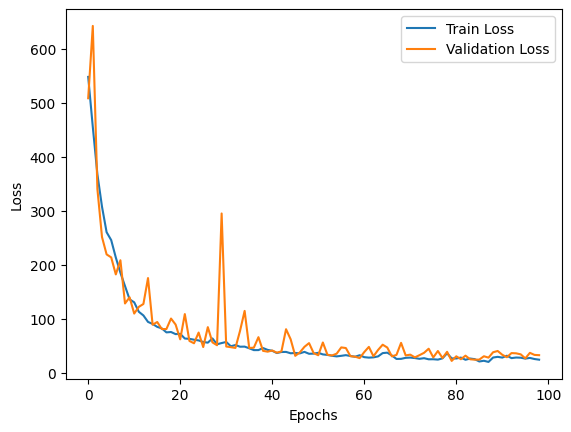

Inference time per 1000 samples: 8.3334
Mean Squared Error (MSE): 22.9795
Mean Absolute Error (MAE): 2.7877
R-Squared (R²): 0.9854


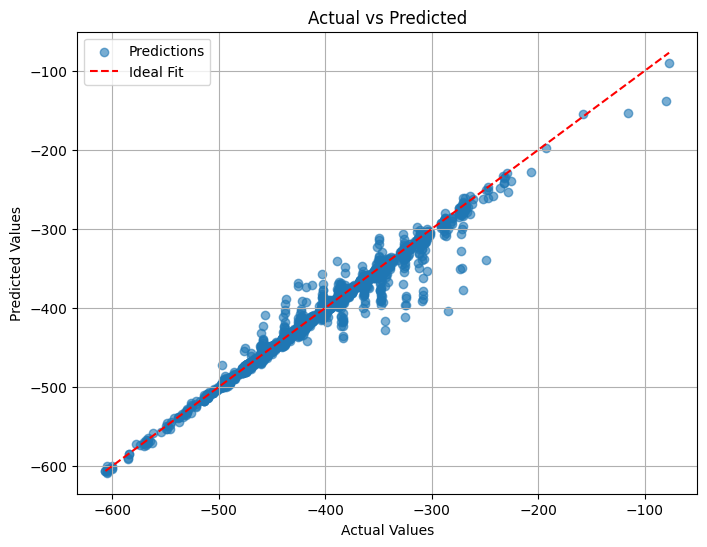

Training with 60.0% Data


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/100], Train Loss: 3825.7319, Validation Loss: 650.5335
Epoch [2/100], Train Loss: 630.2490, Validation Loss: 541.0375
Epoch [3/100], Train Loss: 546.7395, Validation Loss: 565.0702
Epoch [4/100], Train Loss: 489.2659, Validation Loss: 510.9730
Epoch [5/100], Train Loss: 453.6033, Validation Loss: 393.9673
Epoch [6/100], Train Loss: 380.8674, Validation Loss: 381.3898
Epoch [7/100], Train Loss: 338.5548, Validation Loss: 329.3234
Epoch [8/100], Train Loss: 292.7565, Validation Loss: 247.1859
Epoch [9/100], Train Loss: 273.2610, Validation Loss: 249.6356
Epoch [10/100], Train Loss: 248.7560, Validation Loss: 199.2355
Epoch [11/100], Train Loss: 212.0918, Validation Loss: 229.4715
Epoch [12/100], Train Loss: 199.5306, Validation Loss: 232.9984
Epoch [13/100], Train Loss: 194.6224, Validation Loss: 173.6489
Epoch [14/100], Train Loss: 166.7088, Validation Loss: 175.1832
Epoch [15/100], Train Loss: 156.8430, Validation Loss: 152.3441
Epoch [16/100], Train Loss: 143.9287, Validation

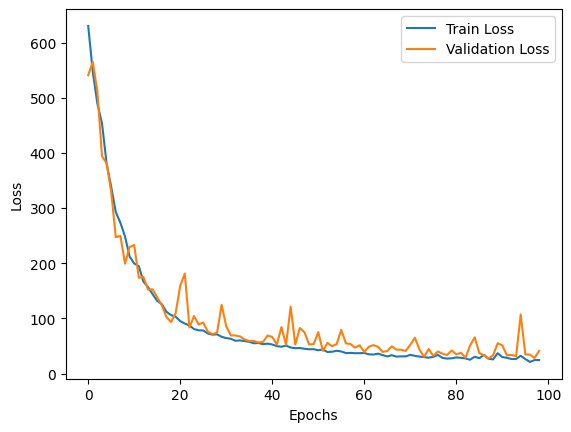

Inference time per 1000 samples: 8.3479
Mean Squared Error (MSE): 45.2777
Mean Absolute Error (MAE): 3.3917
R-Squared (R²): 0.9708


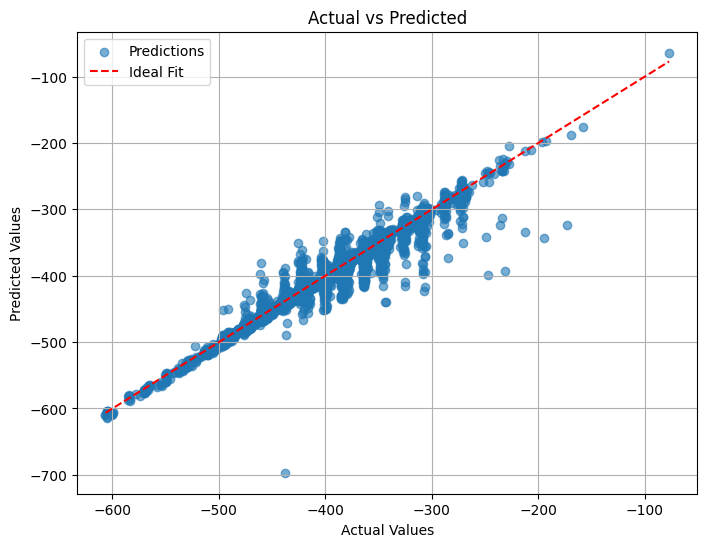

Training with 45.0% Data


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/100], Train Loss: 5444.6448, Validation Loss: 624.9185
Epoch [2/100], Train Loss: 641.9609, Validation Loss: 655.8533
Epoch [3/100], Train Loss: 566.3767, Validation Loss: 483.1569
Epoch [4/100], Train Loss: 491.2523, Validation Loss: 494.2452
Epoch [5/100], Train Loss: 441.4082, Validation Loss: 422.2537
Epoch [6/100], Train Loss: 395.6070, Validation Loss: 385.3208
Epoch [7/100], Train Loss: 349.7051, Validation Loss: 374.5181
Epoch [8/100], Train Loss: 311.5425, Validation Loss: 316.0954
Epoch [9/100], Train Loss: 288.0903, Validation Loss: 263.9304
Epoch [10/100], Train Loss: 257.3959, Validation Loss: 301.7317
Epoch [11/100], Train Loss: 233.5086, Validation Loss: 220.9461
Epoch [12/100], Train Loss: 219.1186, Validation Loss: 180.5473
Epoch [13/100], Train Loss: 199.5827, Validation Loss: 195.2618
Epoch [14/100], Train Loss: 187.7026, Validation Loss: 160.6379
Epoch [15/100], Train Loss: 175.1024, Validation Loss: 188.1447
Epoch [16/100], Train Loss: 160.8330, Validation

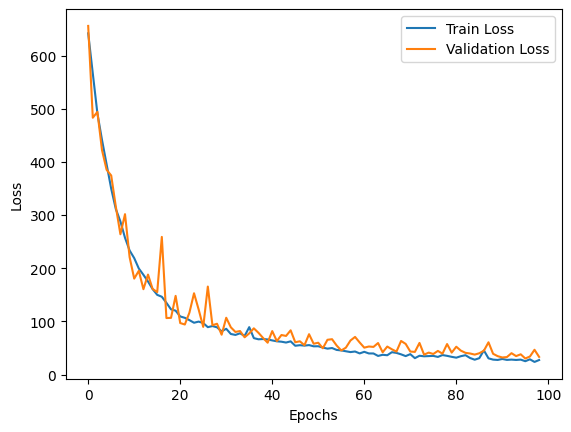

Inference time per 1000 samples: 8.3599
Mean Squared Error (MSE): 33.4616
Mean Absolute Error (MAE): 2.9739
R-Squared (R²): 0.9787


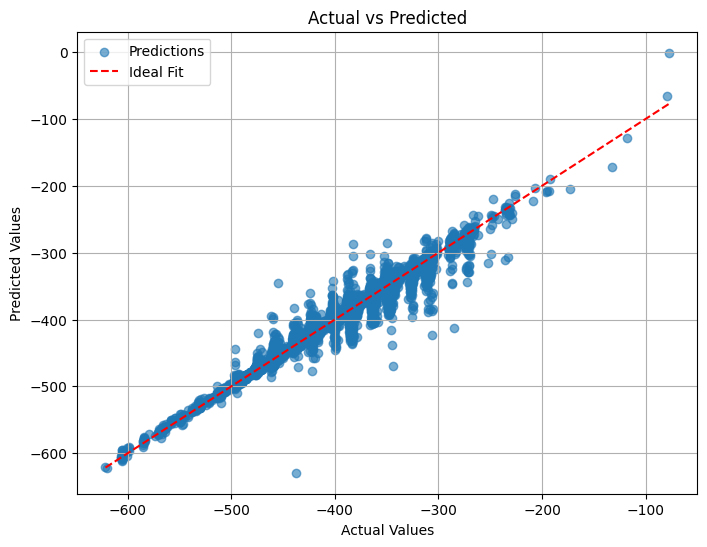

Training with 30.0% Data


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/100], Train Loss: 6921.1256, Validation Loss: 725.7724
Epoch [2/100], Train Loss: 666.1005, Validation Loss: 715.9622
Epoch [3/100], Train Loss: 613.5695, Validation Loss: 655.0034
Epoch [4/100], Train Loss: 562.9314, Validation Loss: 718.9062
Epoch [5/100], Train Loss: 533.3638, Validation Loss: 597.3339
Epoch [6/100], Train Loss: 483.5345, Validation Loss: 513.5582
Epoch [7/100], Train Loss: 455.7076, Validation Loss: 423.5203
Epoch [8/100], Train Loss: 418.5981, Validation Loss: 375.4944
Epoch [9/100], Train Loss: 392.2378, Validation Loss: 394.8213
Epoch [10/100], Train Loss: 345.0794, Validation Loss: 311.8917
Epoch [11/100], Train Loss: 319.1159, Validation Loss: 285.9653
Epoch [12/100], Train Loss: 291.1596, Validation Loss: 307.5084
Epoch [13/100], Train Loss: 269.3986, Validation Loss: 276.5869
Epoch [14/100], Train Loss: 248.6547, Validation Loss: 342.3044
Epoch [15/100], Train Loss: 235.9324, Validation Loss: 317.9596
Epoch [16/100], Train Loss: 220.5630, Validation

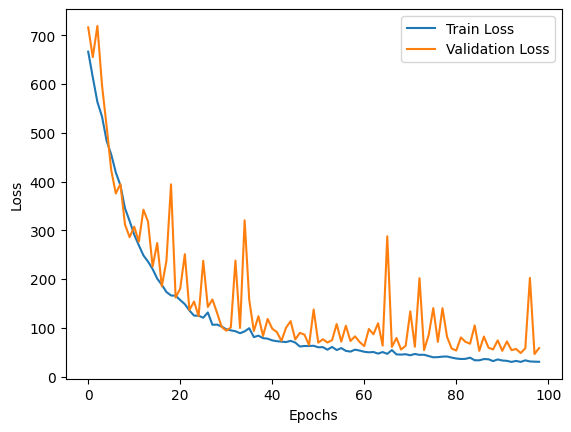

Inference time per 1000 samples: 8.3064
Mean Squared Error (MSE): 58.0983
Mean Absolute Error (MAE): 4.7256
R-Squared (R²): 0.9633


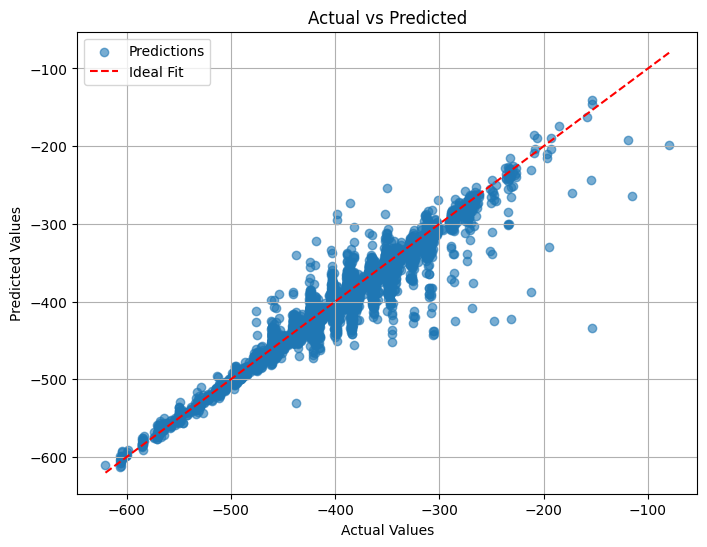

Training with 15.0% Data


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/100], Train Loss: 13372.3266, Validation Loss: 788.0152
Epoch [2/100], Train Loss: 798.6521, Validation Loss: 671.2627
Epoch [3/100], Train Loss: 714.0094, Validation Loss: 753.0928
Epoch [4/100], Train Loss: 666.3206, Validation Loss: 669.7489
Epoch [5/100], Train Loss: 650.2757, Validation Loss: 864.9564
Epoch [6/100], Train Loss: 639.9471, Validation Loss: 535.2485
Epoch [7/100], Train Loss: 599.8608, Validation Loss: 630.0068
Epoch [8/100], Train Loss: 553.8646, Validation Loss: 595.0219
Epoch [9/100], Train Loss: 548.3563, Validation Loss: 645.2281
Epoch [10/100], Train Loss: 518.1800, Validation Loss: 623.7510
Epoch [11/100], Train Loss: 491.3537, Validation Loss: 708.4225
Epoch [12/100], Train Loss: 481.7011, Validation Loss: 548.3629
Epoch [13/100], Train Loss: 437.2186, Validation Loss: 426.4915
Epoch [14/100], Train Loss: 426.9052, Validation Loss: 530.6990
Epoch [15/100], Train Loss: 428.4620, Validation Loss: 507.4118
Epoch [16/100], Train Loss: 405.3440, Validatio

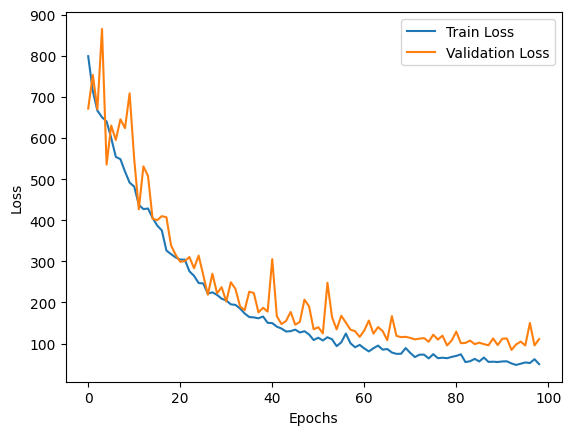

Inference time per 1000 samples: 8.3950
Mean Squared Error (MSE): 105.5618
Mean Absolute Error (MAE): 6.6468
R-Squared (R²): 0.9340


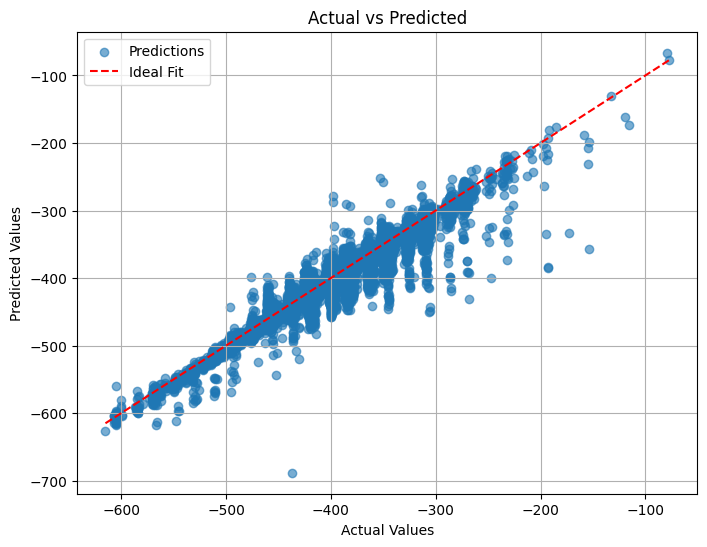

In [12]:
train_sizes = [0.75, 0.6, 0.45, 0.3, 0.15]

for train_size in train_sizes:
    print(f"Training with {train_size*100}% Data")
    model = GNN(node_feat_dim=30, edge_feat_dim=11, hidden_dims=[256, 128, 64], attn_heads=4, use_attention=True)
    run_pipeline(model, data_list, epochs=100, train_size=train_size)